In [1]:
%matplotlib notebook
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torch.distributions import Normal

In [11]:
T = 1024  # number of frames
lr = 0.1  # learning rate
gamma = 0.99  # scheduler parameter

def f(mu):
    Sigma = torch.Tensor([[1.3, 1], [1, 1.3]])
    t = torch.Tensor([0, 1])
    return torch.einsum('...i,...j,ij->...', (t - mu, t - mu, Sigma))

In [12]:
# estimate 1
mu = torch.Tensor([3, -1]).requires_grad_(True)
optimizer = torch.optim.SGD([mu,], lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
reinf_traj = torch.empty(2, T)

for t in range(T):
    q = Normal(mu, torch.ones_like(mu))
    mu_sample = q.sample()
    # gradient estimation magic
    loss = (f(mu_sample) * q.log_prob(mu_sample)).sum()
    loss.backward()
    reinf_traj[:, t] = mu.detach()
    
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

In [13]:
# estimate 2  
mu = torch.Tensor([3, -1]).requires_grad_(True)
optimizer = torch.optim.SGD([mu,], lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
repar_traj = torch.empty(2, T)
    
for t in range(T):
    q = Normal(mu, torch.ones_like(mu))
    mu_sample = q.rsample()
    # gradient estimation magic
    loss = f(mu_sample)
    loss.backward()
    repar_traj[:, t] = mu.detach()
    
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

<IPython.core.display.Javascript object>


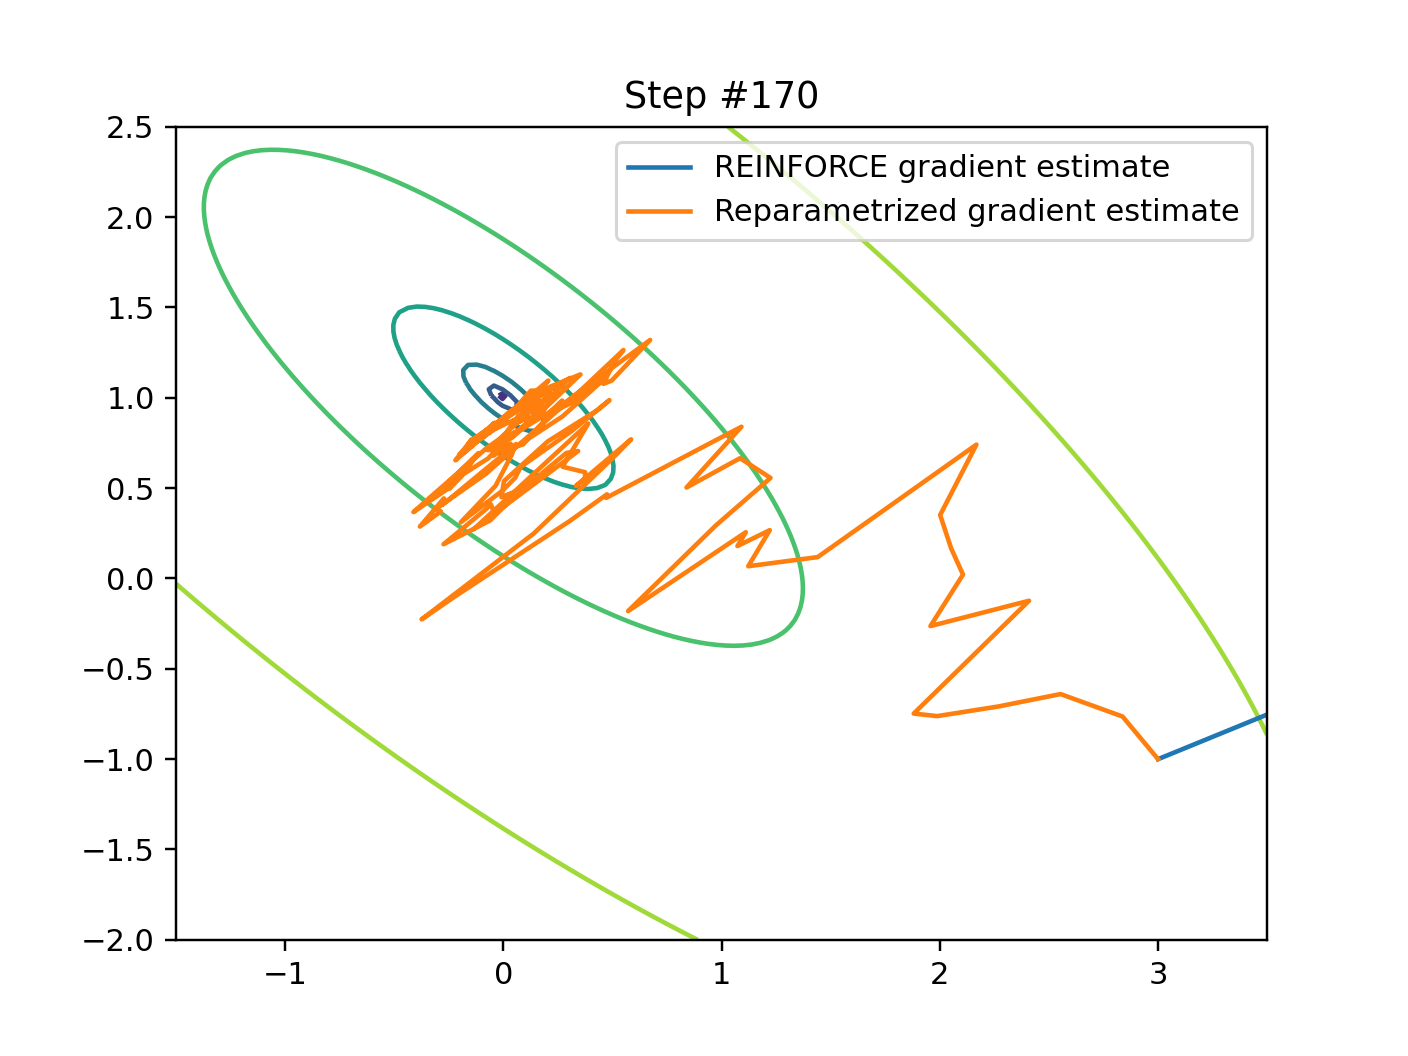

In [14]:
fig, ax = plt.subplots()
xdata, ydata = [], []
reinf, = plt.plot([], [], label='REINFORCE gradient estimate')
repar, = plt.plot([], [], label='Reparametrized gradient estimate')

def init():
    x = torch.linspace(-1.5, 3.5, 128)
    y = torch.linspace(-2, 2.5, 128)
    X, Y = torch.meshgrid(x, y)
    Z = f(torch.stack([X, Y], 2))

    ax.set_xlim(-1.5, 3.5)
    ax.set_ylim(-2, 2.5)
    ax.contour(X, Y, Z.log())
    ax.legend()
    return reinf, repar

def update(t):
    if t % 10 == 0:
        ax.set_title('Step #{}'.format(t))
    reinf.set_data(reinf_traj[0, :t], reinf_traj[1, :t])
    repar.set_data(repar_traj[0, :t], repar_traj[1, :t])
    return reinf, repar

ani = FuncAnimation(fig, update, frames=range(T),
                    init_func=init, blit=True, interval=50)
plt.show()